### QAOA - Bayes
Applicazione di un processo di ottimizzazione bayesiana al QAOA.

### Imports

In [1]:
import numpy as np
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt 
from   matplotlib import cm
from   matplotlib.ticker import LinearLocator, FormatStrFormatter
from qiskit import Aer, IBMQ
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute
from qiskit.visualization import plot_histogram, plot_state_city
import random
import itertools
from tqdm import tqdm
from scipy.optimize import minimize

#mpl.rc('text', usetex = True)
#mpl.rc('font', family = 'serif')

### Qaoa
alcuni metodi per runnare il qaoa con qiskit
- Create graph: crea un grafo random
- draw graph: disegna
- cost function: calcola l'energia classica di una configurazione di bits
- classical solution: calcola quale è la max clique provando tutte le 2^n combinazioni
- quantum algorithm: restituisce l'algorithm qusntistico che applica il qaoa
- Qaoa: accetta i parametri beta e gamma e restituisce l'energia dopo aver applicato un giro del circuito
- grid search: Cerca i parametri migliori con grid search
- plot_f1_landscape: disegna il landscape della funzione costo, dell'energia

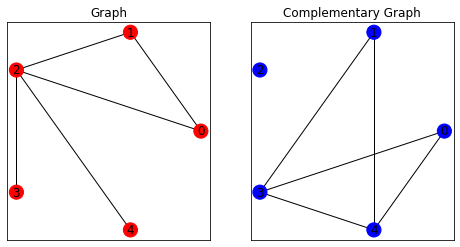

In [5]:
omega = 2
shots = 1000

def create_graph(n, prob_conn, M = 0):
    '''
    Creates a graph of N edges with a probablity of connectivity of each edge: prob_conn
    M decides the maxclique:
        if M is 0 the maxclique will be randomly generated
        if M>0 there will be a maxclique of at least M
    '''
    
    if prob_conn > 1:
        raise ValueError("Prob needs to be lower than 1")
    N = n
    print(N)
    prob_connectivity = prob_conn
    V   = np.arange(0,n,1)
    E = []
    
    #Creates generic graph with at least one connection per every vertex
    for i in range(n):
        one_edge_minimum = False
        for j in range(n):
            if i!=j and (j,i,1.0) not in E and np.random.rand()<prob_connectivity:
                E.append((i,j, 1.0))
                one_edge_minimum = True
        if not one_edge_minimum:
            choose = np.ones(n)/(n-1)
            choose[i] = 0
            E.append((i, np.random.choice(range(n), p = choose), 1))
    
    #Makes sure there is at least a M-large clique
    if M>0:
        max_clique = random.sample(range(0, n), M)
        for i in max_clique:
            for j in max_clique:
                if i!=j and ((j,i,1.0) not in E) and ((i,j,1.0) not in E):
                    E.append((i,j,1.0))
    G = nx.Graph()
    G_comp = nx.Graph()
    G.add_nodes_from(V)
    G.add_weighted_edges_from(E)
    G_comp = nx.complement(G)  
    
    return G

def create_graph_specific(graph_type):
    '''
    Creates preset graphs decided by graph-type:
    graph-type:
        -- simple7: a simple 7 vertex graph with a 4 max clique
        -- simple4: a simple 4 vertex graph with a 3 max clique
        -- simple5: a simple 5 vertex graph with a 3 max clique
    '''
    if graph_type == 'simple7':
        N=7
        V   = np.arange(0,N,1)
        E = []
        E     =[(0,1,1.0),(0,2,1.0),(0,3,1),(1,2,1.0),(1,3,1),(3,2,1.0),(3,4,1.0),(2,5,1.0), (2,6,1)] 
    if graph_type == 'simple4':
        N=4
        V   = np.arange(0,N,1)
        E = []
        E     =[(0,1,1.0),(0,2,1.0),(1,2,1),(2,3,1.0)] 
        
    if graph_type == 'simple5':   
        N   = 5
        V   = np.arange(0,N,1)
        E = [(0,1,1), (1,2,1), (0,2,1), (2,3,1), (3,4,1)]
    
    if graph_type == 'simple6':
        N=6
        V   = np.arange(0,N,1)
        E = []
        E     = [(0, 2, 1), (0, 1, 1), (1, 4, 1), (1, 2, 1), (1, 3, 1), (2, 4, 1)]
                   
    G = nx.Graph()
    G_comp = nx.Graph()
    G.add_nodes_from(V)
    G.add_weighted_edges_from(E)
    G_comp = nx.complement(G)     
    
    return G

def draw_graph(comp = False):
    '''
    Draws given graph G and its complement G if comp = True
    '''
    if comp:
        G_complement = nx.complement(G)
        fig, axis = plt.subplots(nrows = 1, ncols = 2, figsize = (8,4))
    else:
        fig, axis = plt.subplots(111, figsize = (4,4))
    
    colors       = ['r' for node in G.nodes()]
    default_axes = axis[0]
    pos          = nx.circular_layout(G)
    axis[0].set_title('Graph')
    first_graph = nx.draw_networkx(G, node_color=colors, node_size=200, alpha=1, ax=default_axes, pos=pos)
    
    if comp:
        colors       = ['b' for node in G_complement.nodes()]
        default_axes = axis[1]
        pos          = nx.circular_layout(G_complement)
        axis[1].set_title('Complementary Graph')
        nx.draw_networkx(G_complement, node_color=colors, node_size=200, alpha=1, ax=default_axes, pos=pos)
        
def cost_function(values):
    '''
    Evaluates cost of the +1/-1 combination of spins
    '''
    var = 1 - 2*values
    first_term = 1/2*sum(var)
    second_term = 0
    for edge in G_comp.edges:
        second_term += 1/4*omega*(var[edge[0]]*var[edge[1]] - var[edge[0]] - var[edge[1]])
    return first_term + second_term 

def classical_solution():    
    '''
    Runs through all 2^n possible configurations and estimates how many max cliques there are and plots one
    '''
    
    #Evaluate for every possible configuration
    lst = list(itertools.product([0, 1], repeat=len(G)))
    results = {}
    for i in tqdm(range(2**len(G))):
        results[lst[i]] = cost_function(np.array(lst[i]))
    
    print('All possible solutions: \n')
    sol = np.unique(list(results.values()), return_counts = True)
    print(sol[0])
    print(sol[1])
    d = dict((k, v) for k, v in results.items() if v == np.min(list(results.values())))
    print('There are {} MAXCLIQUE(S) with energy: \n'.format(len(d)), d)
    
    fig = plt.figure(figsize=(6, 6))
    val, counts = np.unique(list(results.values()), return_counts = True)
    plt.bar(val, counts)
    plt.xlabel('Energy')
    plt.ylabel('Counts')
    plt.title('Statistics of solutions')

    #PLot one of the largest cliques
    fig = plt.figure(figsize = (4,4))
    plt.title('MaxClique')
    colors       = list(d.keys())[0]
    pos          = nx.circular_layout(G)
    nx.draw_networkx(G, node_color=colors, node_size=200, alpha=1, pos=pos)
    
    return d

def quantum_algorithm(gamma, beta):
    qc = QuantumCircuit(N,N)

    #prepare state
    qc.h(range(N))

    for edge in G_comp.edges:
        qc.rzz(2*gamma*omega/4, edge[0], edge[1])
        qc.rz(-2*gamma*omega/4, edge[0])
        qc.rz(-2*gamma*omega/4, edge[1])
        
    for i in G.nodes:
        qc.rz(2*gamma/2, i)
        
    #mixing
    qc.rx(2*beta, range(N)) #rx = e^[-i(theta/2) X]
    
    meas = QuantumCircuit(N,N)
    meas.barrier(range(N))
    meas.measure(range(N), range(N))

    return qc + meas

def QAOA(params):
    '''
    Applies QAOA
    '''
    gamma = params[0]
    beta = params[1]
    
    backend= Aer.get_backend("qasm_simulator")
    qc = quantum_algorithm(gamma, beta)
    simulate     = execute(qc, backend=backend, shots=shots)
    results = simulate.result()
    extimated_f1 = 0
    counts = results.get_counts()
    for combination in counts:
        comb_to_extimate = np.array([int(x) for x in combination])[::-1]
        extimated_f1 += cost_function(comb_to_extimate)*counts[combination]/shots 
    return extimated_f1, counts

def grid_search(num_params):
    '''
    Grid search
    '''
    #Cretes params
    samp = np.linspace(0, np.pi, num_params)
    params = np.array(list((itertools.product(samp, repeat = 2))))
    gammas = params[:, 0]
    betas = params[:, 1]
    
    QAOA_results = []
    for i in tqdm(range(params.shape[0])):
        res, _ = QAOA([gammas[i], betas[i]])
        QAOA_results.append(res)
    
    return params, QAOA_results

def plot_f1_landscape(params, f1):
    fig = plt.figure()

    # Make data.
    X = np.unique(params[:,0])
    Y = np.unique(params[:,1])
    X, Y = np.meshgrid(X, Y)
    Z = np.reshape(f1, (len(X), len(Y)))

    # Plot the surface.
    plt.imshow(Z, extent = [0, np.pi, np.pi, 0])
    plt.title('Grid Search: [{} x {}]'.format(len(X), len(X)))
    #ticks = np.linspace(0, np.pi, len(X))[::4]
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    
    cb = plt.colorbar()
    plt.xlabel(r'$\gamma$', fontsize=20)
    plt.ylabel(r'$\beta$', fontsize =20)
    cb.ax.tick_params(labelsize=15)
    
def minimize_QAOA():
    minimizer_results = minimize(QAOA, x0 =np.random.uniform(size = 2),
                        method = 'COBYLA', options = {'maxiter' : 1000})
    print(minizer_results)
    return minizer_results

def plot_distribution(C):
    mpl.rc('text', usetex = False)
    #mpl.rc('font', family = 'serif')

    C = dict(sorted(C.items(), key=lambda item: item[1], reverse=True))
    color_dict = {key: 'g' for key in C}
    #indexes = ['01011', '00111']  # MIS indexes
    #for i in indexes:
    #   color_dict[i] = 'red'
    plt.figure(figsize=(12,6))
    plt.xlabel("bitstrings")
    plt.ylabel("counts")
    plt.bar(C.keys(), C.values(), width=0.5, color = color_dict.values())
    plt.xticks(rotation='vertical')
    plt.show()
    
draw_graph(G)

In [6]:
from collections import defaultdict
from itertools import product
def cost_function_var(values, omega):
    '''
    Evaluates cost of the +1/-1 combination of spins
    '''
    var = values
    first_term = -sum(var)
    second_term = 0
    for edge in G_comp.edges:
        second_term += omega*(var[edge[0]]*var[edge[1]] - var[edge[0]] - var[edge[1]])
    return first_term + second_term

dict_strings = defaultdict(list)
for x in product([0,1], repeat = 5):
    for omega in np.arange(-2, 5, 1):
        dict_strings[str(x)].append(cost_function_var(x, omega))

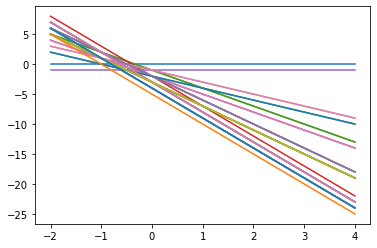

In [7]:
for k, v in dict_strings.items():
    plt.plot(np.arange(-2, 5, 1), v, label = k)

[1, -1]

In [6]:
import networkx as nx
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from itertools import product
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm
from qiskit import Aer, QuantumCircuit, execute
from tqdm import tqdm
import numpy as np

from matplotlib import pyplot as plt


#Set penaly
penalty = 2

#Set shots
shots = 1000

#Set graph instance
E = [(0,1), (1,2), (0,2), (2,3), (2,4)]
N = 5
G = nx.Graph()
G_comp = nx.Graph()
G.add_nodes_from(range(N))
G.add_edges_from(E)
G_comp = nx.complement(G)

def s2z(configuration):
    
    return [1-2*s for s in configuration]

def z2s(s):
    
    return [(1-z)/2 for z in configuration]

def str2list(s):
    
    l = []
    skip=False
    for x in s:
        if skip==True:
            skip=False
            continue
        if x == "-":
            l.append(-1)
            skip=True
        if x != "-":
            l.append(int(x))
    return l

def evaluate_cost(configuration, penalty=penalty, basis=None):
    
    '''
    configuration: eigenvalues
    '''
    
    cost=0
    if basis=="S":
        cost = -sum(configuration)
        for edge in G_comp.edges:
            cost += penalty*(configuration[edge[0]]*configuration[edge[1]])            
    elif basis=="Z":          
        cost = -(len(configuration) - sum(configuration))/2 
        for edge in G_comp.edges:
            cost += penalty/4*(1-configuration[edge[0]])*(1-configuration[edge[1]])
    else:
        raise ValueError('Basis should be specified: it must one of ["S","Z"]')
    return cost

def classical_solution(basis=None, show_top=None):  
    
    '''
    Runs through all 2^n possible configurations and estimates how many max cliques there are and plots one
    '''
    
    results = {}
    eigenvalues = [0,1]
    
    if basis=="S":
        eigenvalues = eigenvalues #[0, 1] i.e. fictitious eigenvalues for |0> ad |1> respectively
    elif basis=="Z": 
        eigenvalues = s2z(eigenvalues) #[1,-1] i.e. fictitious eigenvalues for |0> ad |1> respectively
    else:
        raise ValueError('Basis should be specified: it must one of ["S","Z"]')
        
    configurations = list(product(eigenvalues, repeat=len(G)))
    for configuration in tqdm(configurations):
        results[configuration] = evaluate_cost(configuration, basis=basis)
    
    print('All possible solutions: \n')
    sol = pd.DataFrame(np.unique(list(results.values()), return_counts = True)).T
    sol.columns=["energy","occurrencies"]
    sol["frequency"]=round(sol["occurrencies"]/sol["occurrencies"].sum()*100,0)
    if show_top is not None:
        print(sol.head(show_top))
    else:
        print(sol)
    d = dict((k, v) for k, v in results.items() if v == np.min(list(results.values())))
    print('\nThere are {} MAXCLIQUE(S): '.format(len(d)), d)
    
    fig = plt.figure(figsize=(6, 6))
    val, counts = np.unique(list(results.values()), return_counts = True)
    plt.bar(val, counts)
    plt.xlabel('Energy')
    plt.ylabel('Counts')
    plt.title('Statistics of solutions')

    fig = plt.figure(figsize = (4,4))
    plt.title('MaxClique')
    colors       = list(d.keys())[0]
    pos          = nx.circular_layout(G)
    nx.draw_networkx(G, node_color=colors, node_size=200, alpha=1, pos=pos)
    
#TOCHECK
def quantum_algorithm(gamma, beta, penalty=penalty): #################################################### TO CHECKK #########
   
    qc = QuantumCircuit(N,N)
    qc.h(range(N))
    for edge in G_comp.edges:
        qc.rzz(2*gamma*penalty/4, edge[0], edge[1])
        qc.rz(-2*gamma*penalty/4, edge[0])
        qc.rz(-2*gamma*penalty/4, edge[1])       
    for i in G.nodes:
        qc.rz(2*gamma/2, i)
    qc.rx(2*beta, range(N)) #rx = e^[-i(theta/2) X]
    meas = QuantumCircuit(N,N)
    meas.barrier(range(N))
    meas.measure(range(N), range(N))

    return qc + meas
    
def QAOA(gamma, beta, shots=shots, basis="S"):
    
    '''
    Applies QAOA
    '''

    backend = Aer.get_backend("qasm_simulator")
    qc = quantum_algorithm(gamma, beta)
    simulate = execute(qc, backend=backend, shots=shots)
    results = simulate.result()
    extimated_f1 = 0
    counts = results.get_counts()
    pretty_counts = {k[::-1]:v for k,v in counts.items()} #inverto le chiavi perché quiskit inverte l'ordine
    if basis=="S":
        pass
    elif basis=="Z":
        pretty_counts = {"".join([str(x) for x in s2z([int(x) for x in k])]):v for k,v in pretty_counts.items()}
    else:
        raise ValueError('Basis should be specified: it must one of ["S","Z"]')

    for configuration in pretty_counts:
        prob_of_configuration = pretty_counts[configuration]/shots
        extimated_f1 += prob_of_configuration*evaluate_cost(str2list(configuration), basis=basis)
    
    return extimated_f1, pretty_counts

def grid_search(num_params, shots=shots, basis="S"):
    '''
    Grid search
    '''
        
    QAOA_results = []
    lin = np.linspace(0, np.pi, num_params)
    params = np.array(list((product(lin, repeat = 2))))

    for i in tqdm(range(len(params))):
        res, _ = QAOA(*params[i], shots=shots, basis=basis)
        QAOA_results.append(res)
    
    return params, QAOA_results

def plot_distribution(freq_dict):
    
    sorted_freq_dict = dict(sorted(freq_dict.items(), key=lambda item: item[1], reverse=True))
    color_dict = {key: 'g' for key in C}
    plt.bar(sorted_freq_dict.keys(), sorted_freq_dict.values(), width=0.5, color = color_dict.values())
    plt.figure(figsize=(12,6))
    plt.xlabel("bitstrings")
    plt.ylabel("counts")
    plt.xticks(rotation='vertical')
    plt.show()
    
def plot_distribution(freq_dict):

    sorted_freq_dict = dict(sorted(freq_dict.items(), key=lambda item: item[1], reverse=True))
    color_dict = {key: 'g' for key in sorted_freq_dict}
    plt.figure(figsize=(12,6))
    plt.xlabel("bitstrings")
    plt.ylabel("counts")
    plt.xticks(rotation='vertical')
    plt.bar(sorted_freq_dict.keys(), sorted_freq_dict.values(), width=0.5, color = color_dict.values())
    
def plot_f1_landscape(params, f1):
    
    fig = plt.figure()

    # Make data.
    X = np.unique(params[:,0])
    Y = np.unique(params[:,1])
    X, Y = np.meshgrid(X, Y)
    Z = np.reshape(f1, (len(X), len(Y)))

    # Plot the surface.
    plt.imshow(Z, extent = [0, np.pi, np.pi, 0])
    plt.title('Grid Search: [{} x {}]'.format(len(X), len(X)))
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    
    cb = plt.colorbar()
    plt.xlabel(r'$\gamma$', fontsize=20)
    plt.ylabel(r'$\beta$', fontsize =20)
    cb.ax.tick_params(labelsize=15)

100%|███████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 33596.43it/s]

All possible solutions: 

   energy  occurrencies  frequency
0    -3.0           1.0        3.0
1    -2.0           5.0       16.0
2    -1.0          10.0       31.0
3     0.0           8.0       25.0
4     1.0           2.0        6.0
5     2.0           2.0        6.0
6     3.0           2.0        6.0
7     5.0           1.0        3.0
8     6.0           1.0        3.0

There are 1 MAXCLIQUE(S):  {(-1, -1, -1, 1, 1): -3.0}


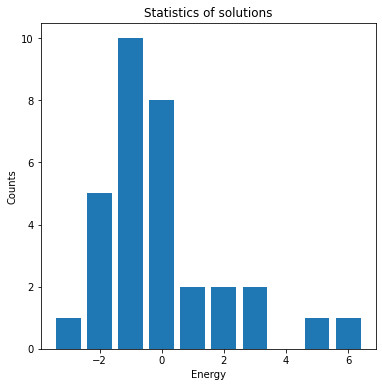

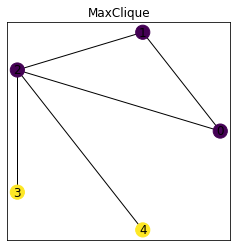

In [2]:
classical_solution(basis="Z")

In [3]:
gamma = 0.2
beta = 0.7
extimated_f1, counts = QAOA(gamma,beta) #da provare con dei valori ottimali!

### Gaussian Process to Approximate the f1 landscape of a graph

Generates $N_{train}$ points selected randomly on a grid $[gamma-extremes] \times [beta-extremes]$, trains a sklearn Gaussin Process Regressor with a kernel defined by kernel and tests it on $N_{test}^2$ samples uniformly picked on a grid $[0, max(gamma, betas)] \times [0, max(gamma, betas)] $. Result is compared to grid search

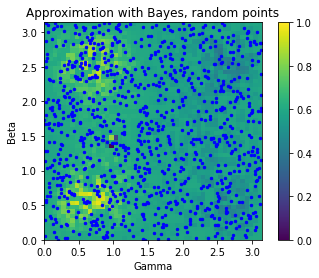

In [4]:
N_train = 1000
N_test = 50
gamma_extremes = [0, np.pi]
beta_extremes = [0, np.pi]
X_train = []; y_train = []

for i in range(N_train):
    X = [np.random.uniform(*gamma_extremes), np.random.uniform(*beta_extremes)]
    X_train.append(X)
    Y, _ = QAOA(*X) #in questi casi la base è inifluente: mi serve solo se sono interessato al secondo argomanto
    y_train.append(Y)

kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=0, normalize_y = True)
gp.fit(X_train, y_train)

X_lin = np.linspace(0, np.max([gamma_extremes, beta_extremes]), N_test)
X_test_grid = list(product(X_lin, X_lin))

predicted_means = gp.predict(X_test_grid) #se volessi anche le std: predicted_means, predicted_sigma = gp.predict(X_test_grid, return_std=True)
res = np.reshape(predicted_means, (N_test, N_test))
X_train = np.array(X_train)
plt.title('Approximation with Bayes, random points')
plt.imshow(res, extent = gamma_extremes + beta_extremes)
plt.scatter(X_train[:,0], X_train[:,1], s=6, c='b')
plt.xlabel('Gamma')
plt.ylabel('Beta')
plt.colorbar()

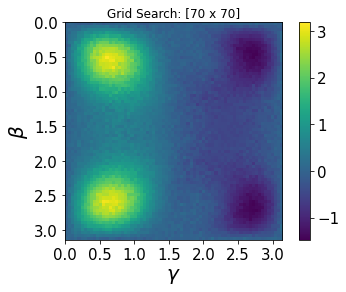

In [7]:
#To confront with
params, f1 = grid_search(70)
plot_f1_landscape(params, f1)

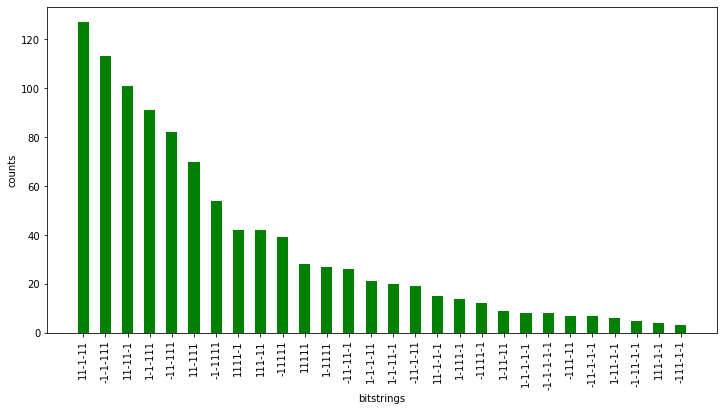

In [16]:
ix_f1_min = np.argmin(f1)
f1_min = f1[ix_f1_min] #è veramente difficile aspettarsi che sia il minimo esatto, perché è un valore di aspettazione
optimal_params = params[ix_f1_min]
extimated_f1, pretty_counts = QAOA(*optimal_params, basis="Z")
plot_distribution(pretty_counts)

### Bayesian Optimization to find the minimum of the f1 of a graph


In [543]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.utils.optimize import _check_optimize_result
from scipy.optimize import minimize

#Allows to change max_iter (see cell below) as well as gtol. It can be straightforwardly extended to other parameters
class MyGaussianProcessRegressor(GaussianProcessRegressor):
    def __init__(self, *args, max_iter=2e05, gtol=1e-06, **kwargs):
        super().__init__(*args, **kwargs)
        self._max_iter = max_iter
        self._gtol = gtol

    def _constrained_optimization(self, obj_func, initial_theta, bounds):
        if self.optimizer == "fmin_l_bfgs_b":
            opt_res = minimize(obj_func, initial_theta, method="L-BFGS-B", jac=True, bounds=bounds, options={'maxiter':self._max_iter, 'gtol': self._gtol})
            _check_optimize_result("lbfgs", opt_res)
            theta_opt, func_min = opt_res.x, opt_res.fun
        elif callable(self.optimizer):
            theta_opt, func_min = self.optimizer(obj_func, initial_theta, bounds=bounds)
        else:
            raise ValueError("Unknown optimizer %s." % self.optimizer)
        return theta_opt, func_min
    
def my_rescaler(x, min_old=0, max_old=np.pi, min_new=0, max_new=1):
    
    x_sc = min_new + (max_new - min_new)/(max_old - min_old)*(x - min_old)
    
    return x_sc

In [549]:
#decide acquisition function
acq_function = 'EI'
N_train = 100
N_test = 50 #Number of test elements
iterations = 100
gamma_extremes = [0, np.pi]  #extremes where to search for the values of gamma and beta
beta_extremes = [0, np.pi]

#create dataset: We start with N random points
X_train = []   #data
y_train = []   #label
np.random.seed(9320)
for i in range(N_train):
    X = [np.random.uniform(gamma_extremes[0],gamma_extremes[1]), np.random.uniform(beta_extremes[0],beta_extremes[1])]
    #X = [.5, 1.5]
    X_train.append(X)
    Y, _ = QAOA(*X, shots=shots, basis="S")
    y_train.append(Y)

X= np.linspace(0, np.max([gamma_extremes, beta_extremes]), N_test)
X_test = list(product(X, X))

X_train = my_rescaler(np.array(X_train)).tolist()
X_test = my_rescaler(np.array(X_test)).tolist()

#create gaussian process and fit training data
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = MyGaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, alpha = 1e-2, normalize_y = True, max_iter = 50000)
gp.fit(X_train, y_train)

#At each iteration we calculate the best point where to sample from
sample_points = []   #We save every point that was chosen to sample from
convergence_check = 0
for i in range(iterations):
        # Test GP
        new_mean, new_sigma = gp.predict(X_test, return_std=True)
        
        #New_mean and new_sigma both are (N_test**2, ) arrays not reshaped yet
        mean_max = np.max(new_mean)
        mean_min = np.min(new_mean)
        
        #Now calculate acquisitition fn as the cumulative for every point centered around the maximum
        cdf = norm.cdf(x = new_mean, loc =  mean_max, scale = new_sigma)
        pdf = norm.pdf(x = new_mean, loc =  mean_min, scale = new_sigma)
    
        #The qdf is instead the probability of being lower then the lowest value of the mean (where we wanto to pick the next_value)
        qdf = 1-norm.cdf(x = new_mean, loc =  mean_min, scale = new_sigma)
    
        if acq_function == 'PI':
            #Next values is calculated as so just because argmax returns a number betwenn 1 and n_test instead of inside the interval
            value = np.argmax(qdf)
            next_point = X_test[value]
            
        if acq_function == 'EI':
            alpha_function = (new_mean - mean_min - 0.001)*qdf + new_sigma*pdf
            #argmax is a number between 0 and N_test**-1 telling us where is the next point to sample
            argmax = np.argmax(np.round(alpha_function, 3))
            next_point_normalized = X_test[argmax]
        
        next_point = my_rescaler(np.array(next_point_normalized), min_old=0, max_old=1, min_new=0, max_new=np.pi)
        X_train.append(next_point_normalized)
        y_next_point,_ = QAOA(*next_point,shots=shots, basis="S")
        y_train.append(y_next_point)
        print(i, next_point, y_next_point, convergence_check)

        gp.fit(X_train, y_train)
        sample_points.append(next_point)
        
        if i>3 and np.sum((np.abs(sample_points[-1] - sample_points[-2] - sample_points[-3]))<1e-3) ==2:
            print('Converged')
            break
print('reached limit')

0 [2.05165235 3.01336438] -0.504 0
1 [1.02582617 2.56456543] -0.4730000000000001 0
2 [2.88513611 2.43633716] -0.8460000000000001 0
3 [0.06411414 2.6927937 ] -0.797 0
4 [1.98753821 2.75690784] -1.0590000000000002 0
5 [2.94925025 2.56456543] -1.239 0
6 [2.94925025 2.62867957] -1.2600000000000002 0
7 [2.94925025 2.62867957] -1.2510000000000001 0
8 [0.06411414 2.5004513 ] -0.8280000000000001 0
9 [2.94925025 2.62867957] -1.2400000000000002 0
10 [2.94925025 2.62867957] -1.2700000000000005 0
11 [2.94925025 2.62867957] -1.302 0
12 [2.94925025 2.62867957] -1.256 0
13 [2.94925025 2.62867957] -1.271 0
14 [2.94925025 2.62867957] -1.2979999999999998 0
15 [2.94925025 2.62867957] -1.2469999999999999 0
16 [2.94925025 2.62867957] -1.249 0
17 [2.94925025 2.62867957] -1.2870000000000001 0
18 [2.94925025 2.62867957] -1.245 0
19 [2.94925025 2.62867957] -1.331 0
20 [2.94925025 2.62867957] -1.3119999999999998 0
21 [2.94925025 2.62867957] -1.3179999999999998 0
22 [2.94925025 2.62867957] -1.2690000000000001 0


In [65]:
#np.savetxt('../data/raw/Bayesian_search_easy.dat', np.array(sample_points))

-0.2180000000000001


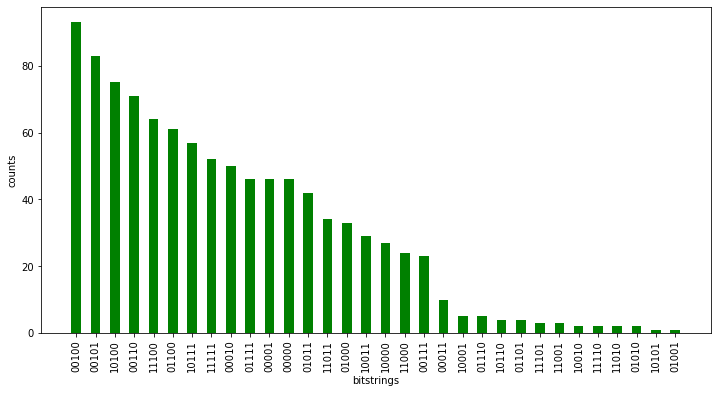

In [551]:
#next_point = [0.64114136, 0.25645654]
next_point = [0.44879895, 2.75690784]
a, r = QAOA(*next_point,shots=shots, basis="S")
plot_distribution(r)
print(a)

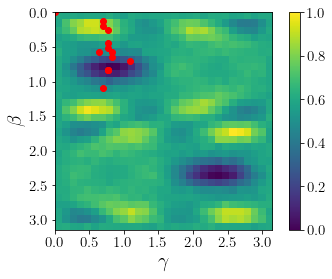

In [33]:
fig = plt.figure()

mpl.rc('text', usetex = True)
mpl.rc('font', family = 'serif')
# Make data.
X = np.unique(params[:,0])
Y = np.unique(params[:,1])
X, Y = np.meshgrid(X, Y)
Z = np.reshape(f1, (len(X), len(Y)))

# Plot the surface.
plt.imshow(Z, extent = [0, np.pi, np.pi, 0])
#plt.title('Minimum search with bayes', fontsize = 15)
sample_points = np.array(sample_points)
plt.scatter(sample_points[:,0], sample_points[:,1], c = 'r')
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

cb = plt.colorbar()
plt.xlabel(r'$\gamma$', fontsize=20)
plt.ylabel(r'$\beta$', fontsize =20)
cb.ax.tick_params(labelsize=15)